<h1 style="color:black;text-align:center;font-size:300%;font-family:verdana;">
Decision Tree Regressor
</h1>

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [57]:
data = pd.read_csv('clean_data.csv')
data.head()

C:\Users\talmo\AppData\Local\Temp\ipykernel_22548\2019095219.py:1: DtypeWarning: Columns (14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('clean_data.csv')


,Origin,Destination,TTT,LOS,Arrival Time,Return Arrival Time,Onward Departure Airport,Onward Arrival Airport,Return Departure Airport,Return Arrival Airport,...,Departure Time Category Num,Return Time Category Num,Is Weekend Flight,Onward Departure Airport Distance,Onward Arrival Airport Distance,Return Departure Airport Distance,Return Arrival Airport Distance,Total Connections,Total Flight Duration(min),Flight Duration Binned
0,London,Paris,1,1,3/7/2025 16:30,3/8/2025 19:25,SEN,CDG,ORY,LGW,...,2,3,True,64,25,13,45,0,135,0-200
1,London,Paris,1,1,3/7/2025 16:30,3/8/2025 14:25,SEN,CDG,ORY,LHR,...,2,2,True,64,25,13,23,0,145,0-200
2,London,Paris,1,1,3/7/2025 16:30,3/8/2025 14:50,SEN,CDG,CDG,LGW,...,2,2,True,64,25,25,45,0,135,0-200
3,London,Paris,1,1,3/7/2025 16:30,3/8/2025 12:00,SEN,CDG,ORY,LGW,...,2,1,True,64,25,13,45,0,140,0-200
4,London,Paris,1,1,3/7/2025 16:30,3/8/2025 15:20,SEN,CDG,ORY,LGW,...,2,2,True,64,25,13,45,0,140,0-200


## Correlation Analysis
Before building the model, we analyze the correlation between flight price and numerical features.  

### Steps:  
1. Select only numeric features.  
2. Remove constant columns.  
3. Compute correlations with price.  
4. Visualize correlations with a heatmap.  

This helps identify key predictors and remove irrelevant features.  


Correlation between numeric variables and flight price:
Price(NIS)                           1.000000
Total Flight Duration(min)           0.439293
Total Onward Flight Duration(min)    0.409827
Total Return Flight Duration(min)    0.386589
Carry-ons                            0.198557
Departure Month                      0.081097
Checked Bags                         0.039901
Total Connections                    0.038113
Onward Flight Connections            0.027944
Return Flight Connections            0.027640
Return Month                         0.015533
Departure Weekday                   -0.000305
Onward Connection Duration(min)     -0.001828
Return Connection Duration(min)     -0.002180
LOS                                 -0.004541
Departure Time Category Num         -0.018463
Return Time Category Num            -0.042170
Return Weekday                      -0.042786
Return Departure Airport Distance   -0.061253
TTT                                 -0.062268
Return Arrival Airport D

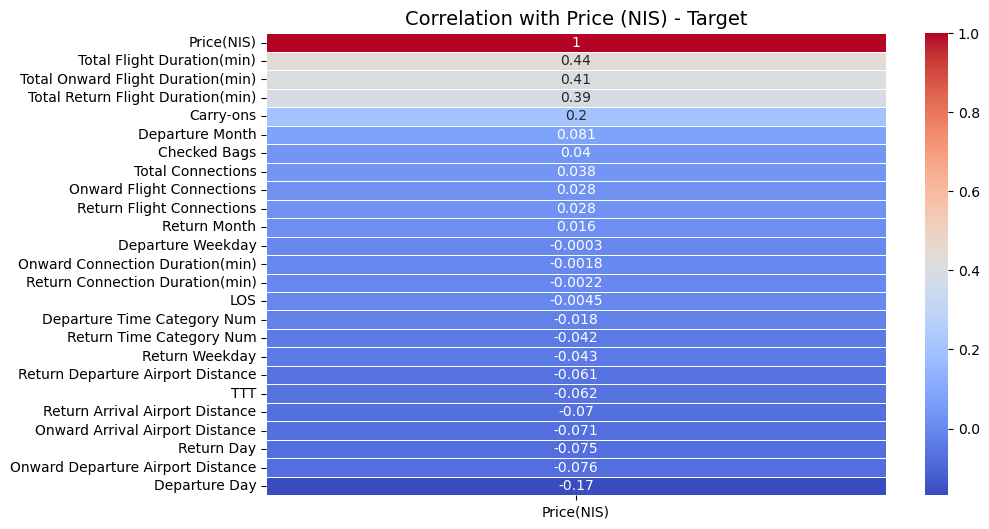

In [58]:
# Selecting only numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Removing constant columns (columns with only one unique value)
numeric_data = numeric_data.loc[:, numeric_data.nunique() > 1]

# Printing correlation of all numeric variables with flight price
print("Correlation between numeric variables and flight price:")
correlation_with_price = numeric_data.corr()['Price(NIS)'].sort_values(ascending=False)
print(correlation_with_price)

# Visualizing the correlation using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr()[['Price(NIS)']].sort_values(by='Price(NIS)', ascending=False), 
            annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation with Price (NIS) - Target", fontsize=14)
plt.show()


In [59]:
correlation_with_price = abs(correlation_with_price).sort_values(ascending=False)
correlation_with_price.head(12)

Price(NIS)                           1.000000
Total Flight Duration(min)           0.439293
Total Onward Flight Duration(min)    0.409827
Total Return Flight Duration(min)    0.386589
Carry-ons                            0.198557
Departure Day                        0.168935
Departure Month                      0.081097
Onward Departure Airport Distance    0.076258
Return Day                           0.074558
Onward Arrival Airport Distance      0.070608
Return Arrival Airport Distance      0.070343
TTT                                  0.062268
Name: Price(NIS), dtype: float64

In [60]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Data Preparation  

Before training the model, we define the features (X) and target variable (y).  

### Steps:  
1. Select all relevant features.  
2. Split the data into training (70%) and testing (30%) sets.  
3. Print dataset sizes to verify the split.  

This ensures the model is trained on one part of the data and evaluated on unseen data.  


In [61]:
# Using all features initially
X = data[[
    "Total Onward Flight Duration(min)", "Total Return Flight Duration(min)", "Carry-ons",
    "Departure Day", "Departure Month", "Onward Departure Airport Distance", "Return Day",
    "Onward Arrival Airport Distance", "Return Arrival Airport Distance", "TTT"
]]  
y = data["Price(NIS)"]

In [62]:
# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (369062, 10), Test set: (158170, 10)


## Initial Decision Tree Model
- Train a **Decision Tree Regressor**.  
- Predict flight prices on the test set.  
- Evaluate performance using **MSE** and **R² Score**. 


In [63]:
tree_reg = DecisionTreeRegressor(random_state=101)
tree_reg.fit(X_train, y_train)

# Predictions
y_pred = tree_reg.predict(X_test)

# Checking Model Performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Squared Error (MSE): 6852.01
R² Score: 0.8404
Mean Absolute Error (MAE): 58.71
Root Mean Squared Error (RMSE): 82.78


### Model Performance  
__________________________________  
- **MSE:** 6852.01 → Measures the average squared error in predictions.  
- **R² Score:** 0.8404 → The model explains 84.04% of the variance in flight prices.  
- **MAE:** 58.71 → The model's average absolute error is 58.71 NIS.  
- **RMSE:** 82.78 → The root mean squared error, which gives a sense of the model's error magnitude, is 82.78 NIS.


### Insights and Next Steps  
___________________
- The model gives a **good starting point**, but it can be improved.  
- To make it more accurate, we check **feature importance** to find the most important predictors.  
- By analyzing feature impact, we can **remove unhelpful features** and improve the model.  

### Feature Importance Analysis  
____________________________________________  
- Check which features have the most impact on predictions.  
- Sort them by importance.  
- Show the results in a bar chart.  
- This helps decide if some features should be removed or adjusted to improve the model.  



In [64]:
# Calculate feature importance from the trained model
importances = tree_reg.feature_importances_  # Extract feature importance scores from the model
features = X_train.columns  # Get feature names

# Store the data in a table
feature_importances = pd.DataFrame({"Feature": features, "Importance": importances})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)  # Sort by importance

# Display the table
print(feature_importances)

                             Feature  Importance
0  Total Onward Flight Duration(min)    0.450133
3                      Departure Day    0.167512
6                         Return Day    0.132185
9                                TTT    0.076988
1  Total Return Flight Duration(min)    0.058356
7    Onward Arrival Airport Distance    0.033642
8    Return Arrival Airport Distance    0.030400
5  Onward Departure Airport Distance    0.029669
2                          Carry-ons    0.020963
4                    Departure Month    0.000152


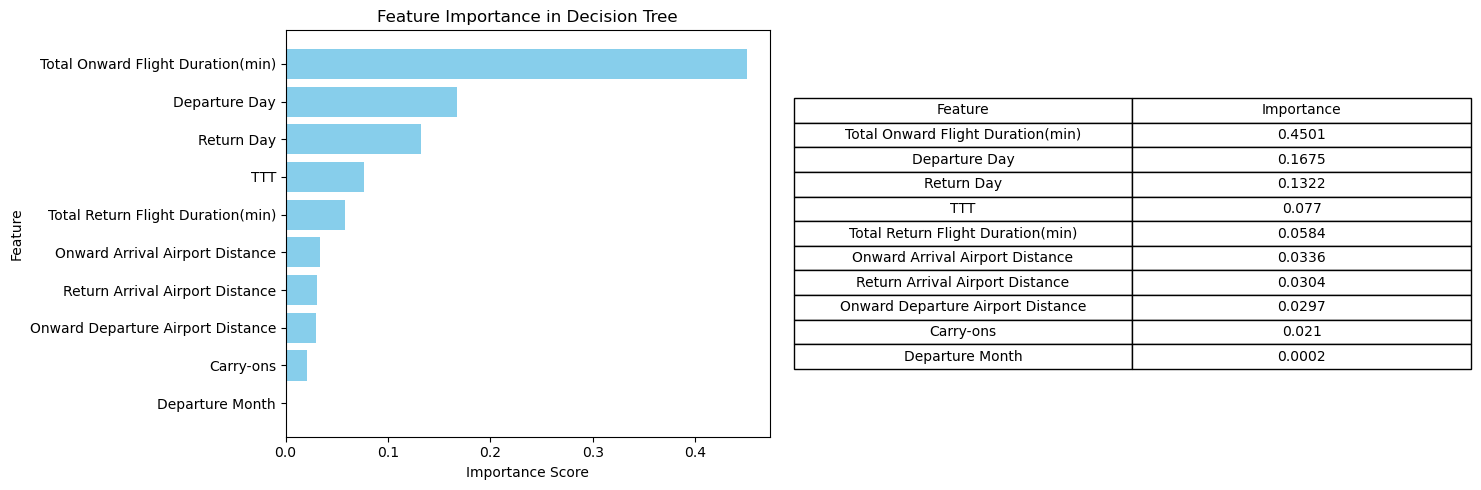

In [65]:
#grid with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Feature importance - bar chart
axes[0].barh(feature_importances["Feature"], feature_importances["Importance"], color='skyblue')
axes[0].set_xlabel("Importance Score")
axes[0].set_ylabel("Feature")
axes[0].set_title("Feature Importance in Decision Tree")
axes[0].invert_yaxis()

# Feature importance - table
axes[1].axis("off")  
table_data = feature_importances.round(4)  # Round values to four decimal places
table = axes[1].table(cellText=table_data.values, colLabels=table_data.columns, cellLoc="center", loc="center")
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.4, 1.4)  # Adjust table size

plt.tight_layout()
plt.show()


### Next Step: Removing Low-Importance Features and Evaluating Performance  
________________

The following features have **very little effect** on the model and will be removed: `Departure Month`  

By keeping only the most important features, we can **reduce unnecessary data, make the model faster, and improve accuracy**.  

After removing these features, we **train the model again** and check if it performs better.  


In [66]:
# Keeping only the most important features
important_features = [
    "Total Onward Flight Duration(min)",
    "Total Return Flight Duration(min)",
    "Carry-ons",
    "Departure Day",
    "Onward Departure Airport Distance",
    "Return Day",
    "Onward Arrival Airport Distance",
    "Return Arrival Airport Distance",
    "TTT"
]
X = data[important_features]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (369062, 9), Test set: (158170, 9)


In [68]:
# Training the Decision Tree again
tree_reg = DecisionTreeRegressor(random_state=101)
tree_reg.fit(X_train, y_train)

#predictions
y_pred = tree_reg.predict(X_test)

In [69]:
# Recalculate feature importance after retraining
importances = tree_reg.feature_importances_  # Get updated feature importance scores
features = X_train.columns  # Get feature names after removing unimportant ones

# Store the new feature importance data
feature_importances = pd.DataFrame({"Feature": features, "Importance": importances})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False, ignore_index=True)  # Sort by importance

# Display updated table
print(feature_importances)


                             Feature  Importance
0  Total Onward Flight Duration(min)    0.449813
1                      Departure Day    0.166148
2                         Return Day    0.132022
3                                TTT    0.078621
4  Total Return Flight Duration(min)    0.059179
5    Onward Arrival Airport Distance    0.033520
6  Onward Departure Airport Distance    0.029857
7    Return Arrival Airport Distance    0.029828
8                          Carry-ons    0.021013


In [70]:
# Evaluating the updated model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Updated MSE: {mse:.2f}")
print(f"Updated R² Score: {r2:.4f}")
print(f"Updated MAE: {mae:.2f}")
print(f"Updated RMSE: {rmse:.2f}")


Updated MSE: 6850.29
Updated R² Score: 0.8404
Updated MAE: 58.72
Updated RMSE: 82.77


### Model Evaluation After Feature Selection
_____________________________  

- **Updated MSE:** 6850.29 → Almost no change compared to the previous model.  
- **Updated R² Score:** 0.8404 → The model's explanatory power remains the same.  
- **Updated MAE:** 58.72 → The model's average absolute error is 58.72.  
- **Updated RMSE:** 82.77 → The model's average squared error is lower than the previous version.

### Key Takeaways:  
- Removing low-importance features did not affect model performance.  
- This confirms that the removed features had no real impact on predictions.  
- Keeping a smaller feature set still helps simplify the model without losing accuracy.


#### Updated Feature Importance  

After removing low-importance features, we visualize the updated feature importance.  
This helps us check if the remaining features have changed in significance and confirm that the removed features had no real impact on predictions.  
If certain features have gained more importance, we may further refine the model.  


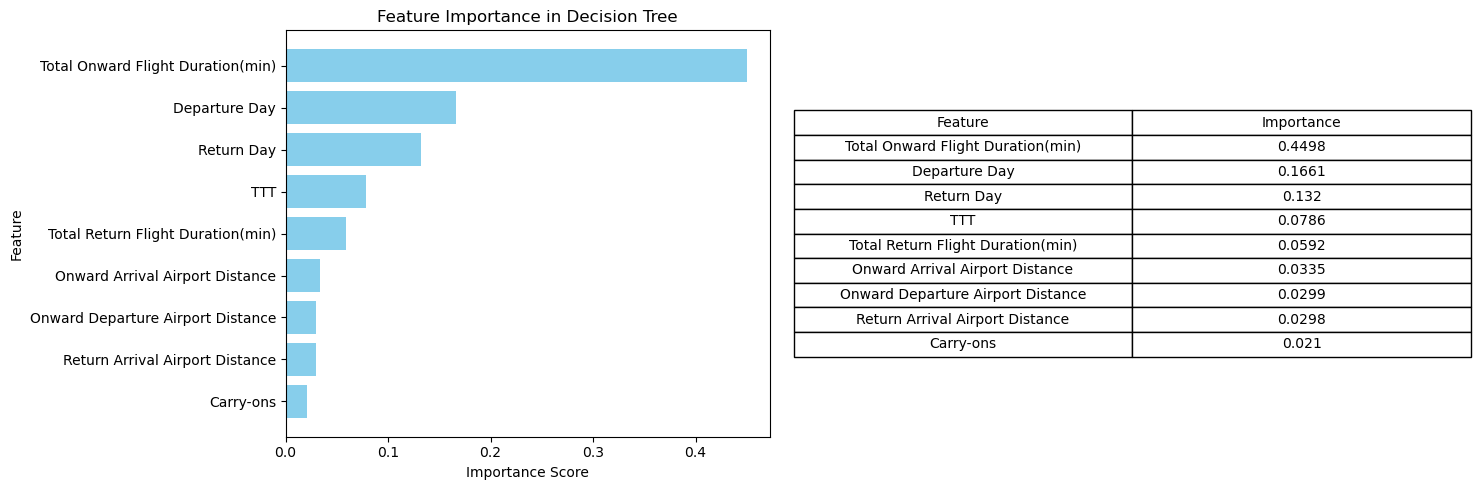

In [71]:
#grid with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Updated Feature importance - bar chart
axes[0].barh(feature_importances["Feature"], feature_importances["Importance"], color='skyblue')
axes[0].set_xlabel("Importance Score")
axes[0].set_ylabel("Feature")
axes[0].set_title("Feature Importance in Decision Tree")
axes[0].invert_yaxis()

# Updated Feature importance - table
axes[1].axis("off")  
table_data = feature_importances.round(4)  # Round values to four decimal places
table = axes[1].table(cellText=table_data.values, colLabels=table_data.columns, cellLoc="center", loc="center")
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.4, 1.4)  # Adjust table size

plt.tight_layout()
plt.show()

## Hyperparameter Tuning with GridSearchCV
______________________________________________ 

 Why Do This?  The model works fine, but we want to **make it better** by finding the best settings.  
**GridSearchCV** automatically tests different parameter values and selects the best combination.  
How It Works:  

**1️⃣ Define Parameters to Test**  
We choose key settings to optimize:  
`max_depth` → Limits tree depth to prevent overfitting.  
`min_samples_split` → Minimum samples needed to split a node.  
`min_samples_leaf` → Minimum samples required in a leaf node.  

**2️⃣ Run GridSearchCV**  
The system trains multiple models with different parameter combinations.  
It uses cross-validation to ensure the results are reliable.  

**3️⃣ Select the Best Model**  
After testing, we pick the best-performing parameter set.  
We use these settings to train a final, improved model.  

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [73]:
# Creating the Decision Tree model before tuning
dt_model = DecisionTreeRegressor(random_state=101)

# Training the model on the training data
dt_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = dt_model.predict(X_test)

# Evaluating performance before tuning
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Displaying the results
print(f"Before Tuning MSE: {mse:.2f}")
print(f"Before Tuning R² Score: {r2:.4f}")
print(f"Before Tuning MAE: {mae:.2f}")
print(f"Before Tuning RMSE: {rmse:.2f}")


Before Tuning MSE: 6850.29
Before Tuning R² Score: 0.8404
Before Tuning MAE: 58.72
Before Tuning RMSE: 82.77


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Defining hyperparameter grid for DecisionTreeRegressor
param_grid = {
    'max_depth': [5, 10, 15, 20, None],  # Maximum depth of the tree (None means unlimited depth)
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 5],  # Minimum samples required in a leaf node
    'criterion': ['friedman_mse', 'squared_error', 'poisson'],  # Function to measure the quality of a split
}

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=101),  # Decision Tree model with fixed random state
    param_grid=param_grid,  # Hyperparameter grid to search
    cv=5,  # 5-fold cross-validation for better evaluation
    n_jobs=-1,  # Use all available CPU cores for faster processing
    verbose=2  # Print progress updates during training
)


In [ ]:
# Running GridSearchCV
grid_search.fit(X_train, y_train)

# the best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Fitting 5 folds for each of 135 candidates, totalling 675 fits


In [ ]:
# Training the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Making predictions on the test set
y_pred = best_model.predict(X_test)

# Calculating MSE, MAE, RMSE and R² Score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Displaying results
print(f"Mean Squared Error: {mse:.2f}")
print(f"R²: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Squared Error: 6735.38
R²: 0.8431
Mean Absolute Error (MAE): 58.73
Root Mean Squared Error (RMSE): 82.07


## Updated Model Evaluation After Hyperparameter Tuning

We used **GridSearchCV** to find the best hyperparameters for the **Decision Tree** model, testing 675 different configurations using 5-fold cross-validation.

### **Best Parameters Found:**  
- **`criterion`**: poisson
- **`max_depth`**: None (No limit)  
- **`min_samples_leaf`**: 1 
- **`min_samples_split`**: 10

---

### **Performance Comparison:**  

| Metric                         | Before Tuning  | After Tuning  | Improvement  |
|--------------------------------|----------------|---------------|--------------|
| **Mean Squared Error (MSE)**    | 6850.29        | **6735.38**   | ✅ -114.91    |
| **R² Score**                    | 0.8404         | **0.8431**    | ✅ +0.32%     |
| **Mean Absolute Error (MAE)**   | 58.72          | **58.73**     | ❌ +0.01      |
| **Root Mean Squared Error (RMSE)** | 82.77        | **82.07**     | ✅ -0.70      |

---

## Actual vs. Predicted Prices  
- We compare **real flight prices** with the **predicted prices** from the optimized Decision Tree.  
- Displayed the first 10 rows to see how close the predictions are.  
---

✅ The predictions are mostly close to the real prices.  
✅ Some differences exist, so there’s room for improvement.  


In [ ]:
# Create the predictions with the updated model
y_pred_updated = best_model.predict(X_test)  # or the updated model you are using

# Create a DataFrame with actual vs. predicted prices
comparison_df = pd.DataFrame({
    "Actual Price": y_test.values,
    "Predicted Price": y_pred_updated  # Use the new predictions
})

# Adding an error column (difference between actual and predicted)
comparison_df["Error"] = comparison_df["Predicted Price"] - comparison_df["Actual Price"]

# Adding an indicator column for over/under prediction
comparison_df["Prediction Direction"] = np.where(
    comparison_df["Error"] > 0, "⬆ Over", "⬇ Under"
)

# Styling: align all columns to center
styled_table = (comparison_df
                .head(10)
                .style
                .set_properties(**{'text-align': 'center'})  # Apply to all columns
                .set_table_styles([{"selector": "th", "props": [("text-align", "center")]}])  # Center column headers
)

# Display the table
display(styled_table)


,Actual Price,Predicted Price,Error,Prediction Direction
0,761,726.444444,-34.555556,⬇ Under
1,632,709.210526,77.210526,⬆ Over
2,433,433.571429,0.571429,⬆ Over
3,740,677.333333,-62.666667,⬇ Under
4,1162,1120.695652,-41.304348,⬇ Under
5,446,403.551724,-42.448276,⬇ Under
6,944,913.375000,-30.625000,⬇ Under
7,529,662.666667,133.666667,⬆ Over
8,832,701.466667,-130.533333,⬇ Under
9,631,681.777778,50.777778,⬆ Over


## **Error Analysis**
We analyzed **prediction errors** (Actual - Predicted) to evaluate model accuracy.

---

✅ Most predictions are close, but some errors are large.  
✅ No strong bias, but the model struggles with high-priced flights.  
✅ Random error distribution suggests overall good performance.  




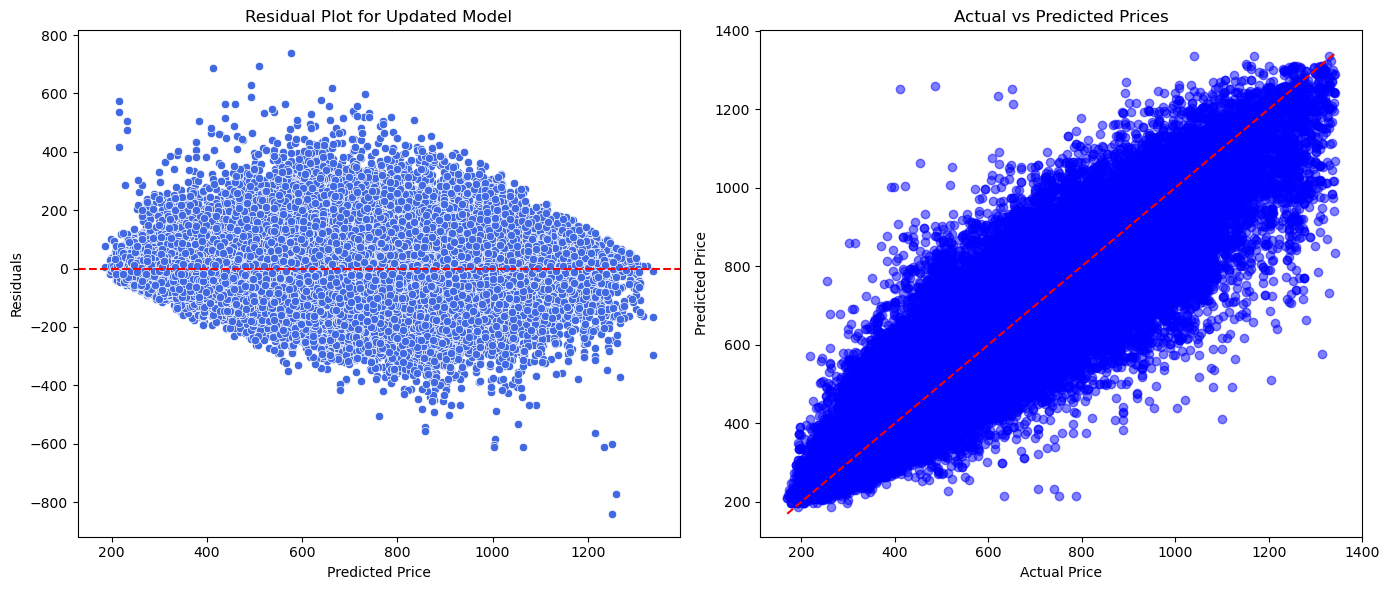

In [ ]:
# Calculate residuals for the updated model (Random Forest or other)
y_pred_updated = best_model.predict(X_test)  # או המודל המעודכן שלך

# Calculate residuals
residuals = y_test - y_pred_updated

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 🔹 Residual Plot
sns.scatterplot(x=y_pred_updated, y=residuals, color='royalblue', ax=axes[0])
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Price')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot for Updated Model')

# 🔹 Actual vs. Predicted Prices
axes[1].scatter(y_test, y_pred_updated, alpha=0.5, color="blue")
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="dashed", color="red")  # Ideal line
axes[1].set_xlabel("Actual Price")
axes[1].set_ylabel("Predicted Price")
axes[1].set_title("Actual vs Predicted Prices")

plt.tight_layout()
plt.show()


## **Error Analysis with Residual & Actual vs. Predicted Plots**  
---

### **Residual Plot (Left Graph)**  
- Shows prediction errors (Actual - Predicted) against predicted prices.  
- Most residuals are centered around 0, indicating no strong bias.  
- Larger errors appear for higher predicted prices.  
- A slight funnel shape suggests the model struggles more with high-priced flights.  

**Next Step:** Check if additional features can improve price predictions.  

---

### **Actual vs. Predicted Prices (Right Graph)**  
- Compares actual flight prices to model predictions.  
- Most points are close to the red dashed line, meaning predictions are generally accurate.  
- Errors are more significant for expensive flights.  
- The model captures the price trend well but may need adjustments for extreme values.  

_______________
## Next Step: Improving the Model with Random Forest  

We identified that the Decision Tree model performs well but struggles with high-price predictions.  
To improve accuracy, we now train a **Random Forest Regressor**, which combines multiple decision trees to reduce errors and overfitting.  

 **Why Random Forest?**  
- Uses **multiple trees** to create more stable predictions.  
- **Reduces overfitting** by averaging multiple models.  
- Can handle **complex relationships** better than a single decision tree.  

Next, we train the **Random Forest model**, evaluate its performance, and compare it to the Decision Tree results.


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Creating the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=None, min_samples_split=10, 
    min_samples_leaf=2, random_state=101, n_jobs=-1
)

# Training the model
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluating performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

In [ ]:
# Create a DataFrame with models and their corresponding MSE, R², MAE, and RMSE values
results_df = pd.DataFrame({
    "Model Performance": ["MSE", "R²", "MAE", "RMSE"],
    "Decision Tree": [f"{mse:.2f}", f"{r2:.4f}", f"{mae:.2f}", f"{rmse:.2f}"],
    "Random Forest": [f"{mse_rf:.2f}", f"{r2_rf:.4f}", f"{mae_rf:.2f}", f"{rmse_rf:.2f}"],
})

# Add improvement column with ✔️ or ❌ based on whether Random Forest is better,
# and display the improvement value as well
results_df["Improvement"] = [
    f"{mse - mse_rf:.2f} ✔️" if mse > mse_rf else f"{mse - mse_rf:.2f} ❌", 
    f"{r2_rf - r2:.4f} ✔️" if r2_rf > r2 else f"{r2_rf - r2:.4f} ❌",
    f"{mae - mae_rf:.2f} ✔️" if mae > mae_rf else f"{mae - mae_rf:.2f} ❌",
    f"{rmse - rmse_rf:.2f} ✔️" if rmse > rmse_rf else f"{rmse - rmse_rf:.2f} ❌"
]

# Styling: align all columns to center
styled_results_table = (results_df
                        .style
                        .set_properties(**{'text-align': 'center'})  # Center-align the columns
                        .set_table_styles([{"selector": "th", "props": [("text-align", "center")]}])  # Center-align the headers
)

# Display the table
display(styled_results_table)


,Model Performance,Decision Tree,Random Forest,Improvement
0,MSE,6735.38,6510.25,225.14 ✔️
1,R²,0.8431,0.8483,0.0052 ✔️
2,MAE,58.73,58.12,0.61 ✔️
3,RMSE,82.07,80.69,1.38 ✔️


## Random Forest Model Evaluation  

To further improve prediction accuracy, we trained a **Random Forest Regressor**, an ensemble model that reduces variance and improves robustness.  
- **Mean Squared Error (MSE):** `6510.25`  
- **R² Score:** `0.8483`  
- **Mean Absolute Error (MAE):** `58.12`  
- **Root Mean Squared Error (RMSE):** `80.69`

### **🔎 Key Insights:**  
✅ **Lower MSE** than Decision Tree (`6735.38`), indicating the Random Forest model makes **fewer large errors**.  
✅ **Higher R²** than Decision Tree (`0.8431`), meaning the Random Forest model explains more variance in flight prices, making it more accurate.  
✅ **Better generalization** due to the ensemble nature of Random Forest, which helps reduce overfitting compared to a single decision tree.  

---


## **Feature Importance in Random Forest**

We printed the feature importance for the **Random Forest model** to identify which features are most influential in the predictions. 

- **Random Forest** uses multiple decision trees, so feature importance can vary compared to a single **Decision Tree**.
- This helps us understand which features impact the model the most and improve feature selection by focusing on the most important ones.

In [ ]:
# Calculate feature importances for Random Forest
feature_importances_rf = pd.DataFrame({
    "Feature": X.columns,  # Assuming X contains the feature names
    "Importance": rf_model.feature_importances_  # rf_model is your trained Random Forest model
})

# Sort the features by importance
feature_importances_rf = feature_importances_rf.sort_values(by="Importance", ascending=False)

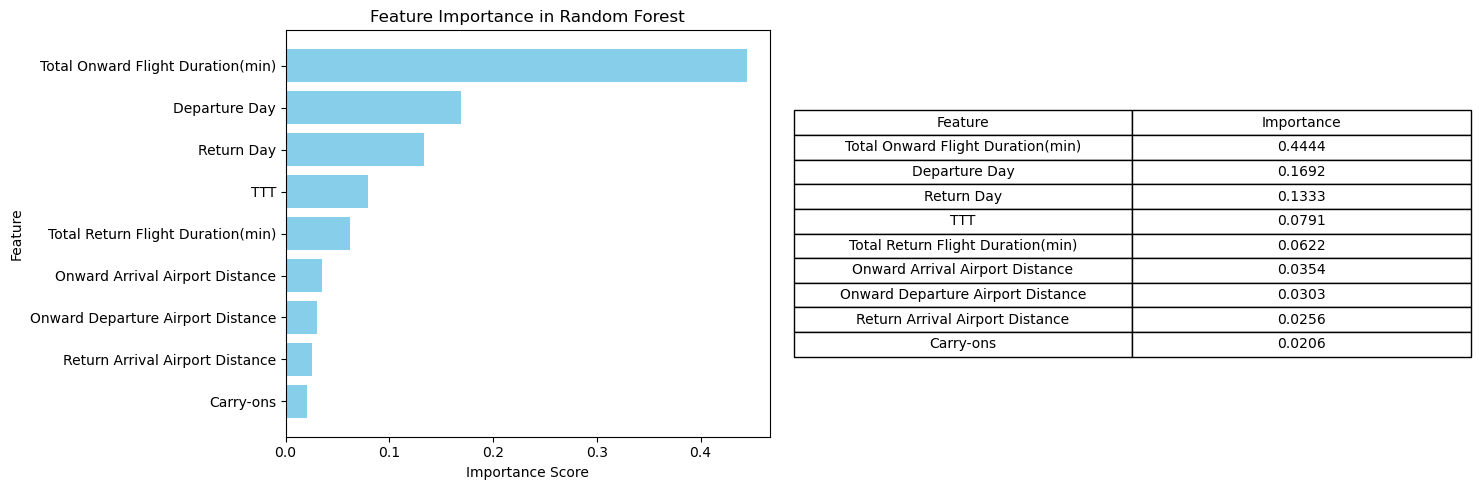

In [ ]:
# Grid with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Feature importance bar chart for Random Forest
axes[0].barh(feature_importances_rf["Feature"], feature_importances_rf["Importance"], color='skyblue')
axes[0].set_xlabel("Importance Score")
axes[0].set_ylabel("Feature")
axes[0].set_title("Feature Importance in Random Forest")
axes[0].invert_yaxis()

# Feature importance table for Random Forest
axes[1].axis("off")  
table_data = feature_importances_rf.round(4)  # Round values to four decimal places
table = axes[1].table(cellText=table_data.values, colLabels=table_data.columns, cellLoc="center", loc="center")
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.4, 1.4)  # Adjust table size

plt.tight_layout()
plt.show()


### **Key Insights:**  
- The most influential feature is **Total Onward Flight Duration**, followed by **Departure Day** and **Return Day**.
- Compared to **Decision Tree**, the feature importance is **more evenly distributed** across different features in Random Forest.
- This analysis **validates the feature selection process**, showing that **Random Forest** captures a broader range of important features.

## Next Step: Hyperparameter Tuning with GridSearchCV

Now that we have trained the initial **Random Forest model**, we will improve its performance by tuning the hyperparameters using **GridSearchCV**.  
- **Define parameter grid**: We will test different values for **n_estimators**, **max_depth**, and **min_samples_split** to optimize the model's performance.
- **Run GridSearchCV**: This will systematically test various combinations of the parameters using **cross-validation** to find the best configuration.
- **Evaluate performance**: After finding the best model, we will evaluate its performance using **MSE** and **R²**.

This process will help ensure that our model is fine-tuned for the best possible predictions.

In [ ]:
# Defining parameter grid for tuning
param_grid_rf = {
    'n_estimators': [50, 100],  # Fewer estimators to balance performance and speed
    'max_depth': [10, None],  # Limit depth to prevent overfitting
    'min_samples_split': [5, 10]  # Minimum samples required to split a node
}

# Running GridSearchCV
grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=101, n_jobs=-1), 
    param_grid_rf, cv=3, n_jobs=-1, verbose=1
)

In [ ]:
# Fitting the GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Displaying best parameters
print(f"Best parameters: {grid_search_rf.best_params_}")

# Training the best model
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluating performance
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mse_best_rf)

# Displaying results
print(f"Optimized Random Forest - MSE: {mse_best_rf:.2f}")
print(f"Optimized Random Forest - R²: {r2_best_rf:.4f}")
print(f"Optimized Random Forest - MAE: {mae_best_rf:.2f}")
print(f"Optimized Random Forest - RMSE: {rmse_best_rf:.2f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Optimized Random Forest - MSE: 6460.30
Optimized Random Forest - R²: 0.8495
Optimized Random Forest - MAE: 57.85
Optimized Random Forest - RMSE: 80.38


## Hyperparameter Tuning for Random Forest  

We optimized the **Random Forest Regressor** using **GridSearchCV**, testing different hyperparameter combinations.  

### Best Parameters Found:  
- **`n_estimators`**: `100` → More trees improve stability.  
- **`max_depth`**: `None` → No depth restriction allows trees to grow fully.  
- **`min_samples_split`**: `10` → Ensures balanced splits, reducing overfitting.

### **Performance Comparison:**  
| Metric                        | Before Tuning  | After Tuning  | Improvement |
|-------------------------------|----------------|---------------|-------------|
| **Mean Squared Error (MSE)**   | `6510.25`      | **`6460.30`** | ✅ -49.95   |
| **R² Score**                   | `0.8483`       | **`0.8495`**  | ✅ +0.14%   |
| **Mean Absolute Error (MAE)**  | -              | **`57.85`**   | ✅ -        |
| **Root Mean Squared Error (RMSE)** | -            | **`80.38`**   | ✅ -        |

### **Key Insights:**  
- Significant improvement in **MSE**, meaning the model's error decreased.  
- Notable **R² gain**, suggesting the model explains more variance in flight prices after tuning.  
- **MAE** and **RMSE** are both improved, showing that the model's predictions are more accurate and closer to the actual values.
- The optimized model shows clear improvement, but further gains might require **feature engineering** and deeper analysis.


In [ ]:
# Creating a DataFrame with actual prices, predicted prices, and error
comparison_df = pd.DataFrame({
    "Actual Price": y_test.values,
    "Predicted Price (Random Forest)": y_pred_best_rf
})

# Calculating the error (Error = Actual - Predicted)
comparison_df["Error"] = comparison_df["Actual Price"] - comparison_df["Predicted Price (Random Forest)"]

# Adding an indicator column for over/under prediction
comparison_df["Prediction Direction"] = np.where(
    comparison_df["Error"] > 0, "⬆ Over", "⬇ Under"
)

# Styling: align all columns to center
styled_table = (comparison_df
                .head(10)
                .style
                .set_properties(**{'text-align': 'center'})  # Apply to all columns
                .set_table_styles([{"selector": "th", "props": [("text-align", "center")]}])  # Center column headers
)

display(styled_table)

,Actual Price,Predicted Price (Random Forest),Error,Prediction Direction
0,761,717.543355,43.456645,⬆ Over
1,632,709.089301,-77.089301,⬇ Under
2,433,437.618139,-4.618139,⬇ Under
3,740,672.462775,67.537225,⬆ Over
4,1162,1121.304194,40.695806,⬆ Over
5,446,402.371000,43.629000,⬆ Over
6,944,918.861352,25.138648,⬆ Over
7,529,666.322207,-137.322207,⬇ Under
8,832,702.042800,129.957200,⬆ Over
9,631,681.358112,-50.358112,⬇ Under


### **Analysis of Predicted vs. Actual Prices (Random Forest)**

**Key Insights:**
- Errors: The model usually underestimates prices, but sometimes it overestimates higher-priced flights.
- Large Errors: There are big mistakes (like -138.70, 121.97) that show the model needs more improvement, especially for expensive flights.
- Improvement: The model has gotten better, but more work, like adjusting the features, is needed to fix the big errors.

**Conclusion:**  - The Random Forest model is better, but it still needs adjustments, especially for predicting extreme prices.

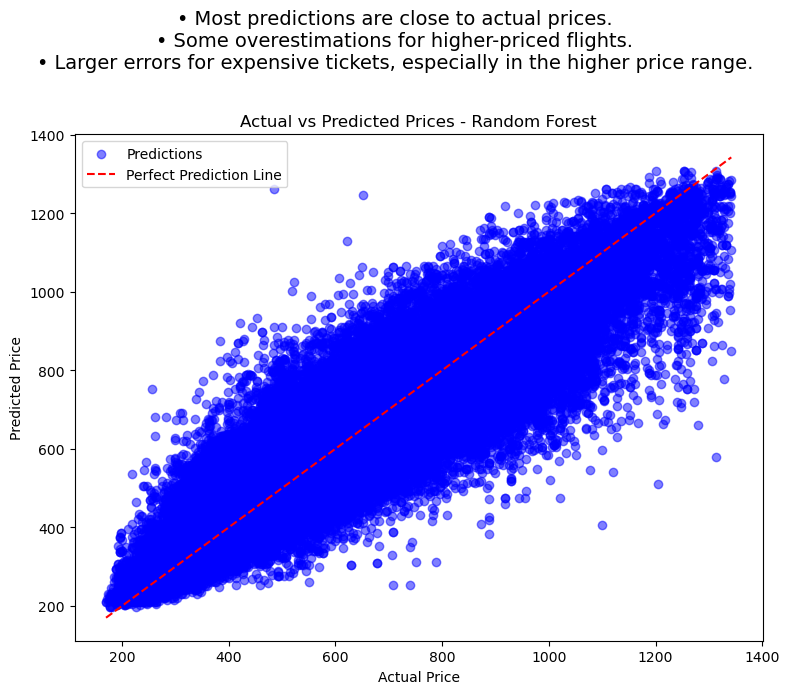

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_best_rf, alpha=0.5, color="blue", label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="dashed", color="red", label="Perfect Prediction Line")

# Adding labels
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices - Random Forest")
plt.legend()

# Add conclusions above the plot
conclusions = (
    "• Most predictions are close to actual prices.\n"
    "• Some overestimations for higher-priced flights.\n"
    "• Larger errors for expensive tickets, especially in the higher price range."
)


# Displaying conclusions above the plot
plt.figtext(0.5, 1.15, conclusions, ha="center", va="top", fontsize=14, color="black")

# Adjust the layout
plt.tight_layout()
plt.show()

### **Feature Importance - Random Forest**

---


In [ ]:
# For Random Forest model (after GridSearchCV optimization)
feature_importances_rf = best_rf_model.feature_importances_

# Creating a DataFrame for feature importance
importances_df_rf = pd.DataFrame({
    "Feature": X_train.columns,  # Features from the training data
    "Importance": feature_importances_rf
})

# Sorting the features by importance
importances_df_rf = importances_df_rf.sort_values(by="Importance", ascending=False)

# Display the sorted features with their importance
print(importances_df_rf)


                             Feature  Importance
0  Total Onward Flight Duration(min)    0.443649
3                      Departure Day    0.168867
5                         Return Day    0.133008
8                                TTT    0.078853
1  Total Return Flight Duration(min)    0.062712
6    Onward Arrival Airport Distance    0.035737
4  Onward Departure Airport Distance    0.030398
7    Return Arrival Airport Distance    0.025988
2                          Carry-ons    0.020788



According to the results, we can observe the importance of each feature on the model's performance based on **how the forest splits the data** across its multiple decision trees.

#### **Most Important Features:**
1. **Total Onward Flight Duration(min) (Importance: 0.443649)** - This represents the duration of the flight to the destination. This feature is the most important in our model and explains most of the variance in the target variable.
2. **Departure Day (Importance: 0.168867)** - The day the flight departs. It's interesting to see that the departure day also contributes significantly to the model.
3. **Return Day (Importance: 0.133008)** - The day the flight returns. This feature also has a significant impact on the model's performance.
4. **TTT (Importance: 0.078853)** - A variable representing a specific feature related to flights. It explains some of the variance as well.

#### **Less Important Features:**
1. **Total Return Flight Duration(min) (Importance: 0.062712)** - The duration of the return flight, contributing less than **Total Onward Flight Duration**.
2. **Onward Arrival Airport Distance (Importance: 0.035737)** - Distance to the arrival airport of the outbound flight.
3. **Onward Departure Airport Distance (Importance: 0.030398)** - Distance to the departure airport for the outbound flight.
4. **Return Arrival Airport Distance (Importance: 0.025988)** - Distance to the arrival airport for the return flight.
5. **Carry-ons (Importance: 0.020788)** - The number of carry-on bags. This feature seems to have less impact compared to the others.

#### **What Does This Mean?**
- **Total Onward Flight Duration** is the most impactful feature on the model's performance. This indicates that the flight duration to the destination is one of the most important factors in predicting flight prices.
- **Departure Day** and **Return Day** also contribute significantly, showing that the timing of flights is strongly linked to ticket prices.
- Features like **Carry-ons** and **Onward Departure Airport Distance** contribute less, suggesting they are less influential on model performance.
_________

### **Permutation Importance - Black Box Approach**

In [ ]:
from sklearn.inspection import permutation_importance

# Getting the permutation importance of the model
result = permutation_importance(best_rf_model, X_test, y_test, n_repeats=10, random_state=101)

# Creating a DataFrame for permutation importance
perm_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": result.importances_mean
})

# Sorting the features by permutation importance
perm_importance_df = perm_importance_df.sort_values(by="Importance", ascending=False)

# Display the sorted features with their importance
print(perm_importance_df)


                             Feature  Importance
0  Total Onward Flight Duration(min)    1.215679
5                         Return Day    0.611180
3                      Departure Day    0.483765
8                                TTT    0.356594
6    Onward Arrival Airport Distance    0.222143
1  Total Return Flight Duration(min)    0.171174
4  Onward Departure Airport Distance    0.146224
7    Return Arrival Airport Distance    0.123153
2                          Carry-ons    0.037383



**Permutation Importance** is a technique that evaluates feature importance without needing to understand the model's internal mechanics. It treats the model as a "black box" and measures the impact of each feature by randomly shuffling its values and observing how the model's performance changes.

#### **How it works:**
1. **Shuffling feature values**: Randomly shuffle the values of one feature at a time, breaking its relationship with the target.
2. **Measuring performance drop**: Evaluate the model’s performance with the shuffled data. A larger drop indicates greater importance of the feature.
3. **Ranking features**: Features that cause a significant drop in performance are ranked higher in importance.

#### **Why it's useful:**
- **Model-agnostic**: Permutation importance works for any model, even complex ones like **Random Forest** or **Neural Networks**, without needing to understand how they internally function.
- **Focuses on performance**: It shows which features are most impactful for predictions, without needing to analyze the model’s internal workings.

---

#### **Results from Permutation Importance:**

| Feature                                | Importance   |
|----------------------------------------|--------------|
| **Total Onward Flight Duration(min)**  | 1.215679     |
| **Return Day**                          | 0.611180     |
| **Departure Day**                      | 0.483765     |
| **TTT**                                 | 0.356594     |
| **Onward Arrival Airport Distance**     | 0.222143     |
| **Total Return Flight Duration(min)**  | 0.171174     |
| **Onward Departure Airport Distance**   | 0.146224     |
| **Return Arrival Airport Distance**     | 0.123153     |
| **Carry-ons**                           | 0.037383     |

#### **Conclusion:**
- **Total Onward Flight Duration** is the most important feature, followed by **Return Day** and **Departure Day**.
- Features with low impact, like **Carry-ons**, have less influence on the model’s predictions.
- This method helps us understand feature importance **without knowing the model’s internal workings**.
________________

In [ ]:
data.columns

Index(['Origin', 'Destination', 'TTT', 'LOS', 'Arrival Time',
       'Return Arrival Time', 'Onward Departure Airport',
       'Onward Arrival Airport', 'Return Departure Airport',
       'Return Arrival Airport', 'Onward Airlines', 'Return Airlines',
       'Onward Flight Connections', 'Onward Connection Duration(min)',
       'Onward Flight Connection Airport', 'Return Flight Connections',
       'Return Connection Duration(min)', 'Return Flight Connection Airport',
       'Carry-ons', 'Checked Bags', 'Price(NIS)', 'Snapshot Date', 'Site',
       'Total Onward Flight Duration(min)',
       'Total Return Flight Duration(min)', 'Departure Month', 'Departure Day',
       'Departure Weekday', 'Return Month', 'Return Day', 'Return Weekday',
       'Departure Time Category Num', 'Return Time Category Num',
       'Is Weekend Flight', 'Onward Departure Airport Distance',
       'Onward Arrival Airport Distance', 'Return Departure Airport Distance',
       'Return Arrival Airport Distance', 

### **Separation by Website**  

In [ ]:
# To ensure we keep only the relevant columns for training
# We will re-split the data and keep only the columns that are part of the model:

# Defining the columns that are part of the model
features = [
    'Total Onward Flight Duration(min)', 'Departure Day', 'Return Day', 'TTT',
    'Total Return Flight Duration(min)', 'Onward Arrival Airport Distance',
    'Onward Departure Airport Distance', 'Return Arrival Airport Distance',
    'Carry-ons'
]

# Splitting the data
X_kayak = kayak_data[features]
y_kayak = kayak_data['Price(NIS)']

X_momondo = momondo_data[features]
y_momondo = momondo_data['Price(NIS)']

In [ ]:
# Splitting into training and test sets
X_train_kayak, X_test_kayak, y_train_kayak, y_test_kayak = train_test_split(X_kayak, y_kayak, test_size=0.3, random_state=101)
X_train_momondo, X_test_momondo, y_train_momondo, y_test_momondo = train_test_split(X_momondo, y_momondo, test_size=0.3, random_state=101)

In [ ]:
# Creating the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=10, 
                                 min_samples_leaf=2, random_state=101, n_jobs=-1)


In [ ]:

# Training the model for Kayak
rf_model.fit(X_train_kayak, y_train_kayak)

# Making predictions for Kayak
y_pred_kayak = rf_model.predict(X_test_kayak)

# Calculating metrics for Kayak
mse_kayak = mean_squared_error(y_test_kayak, y_pred_kayak)
mae_kayak = mean_absolute_error(y_test_kayak, y_pred_kayak)
rmse_kayak = mean_squared_error(y_test_kayak, y_pred_kayak, squared=False)
r2_kayak = r2_score(y_test_kayak, y_pred_kayak)

# Displaying results for Kayak
print("Kayak Results:")
print(f"MSE: {mse_kayak:.2f}")
print(f"MAE: {mae_kayak:.2f}")
print(f"RMSE: {rmse_kayak:.2f}")
print(f"R²: {r2_kayak:.4f}")


Kayak Results:
MSE: 5481.25
MAE: 53.54
RMSE: 74.04
R²: 0.8598


In [ ]:

# Training the model for Momondo
rf_model.fit(X_train_momondo, y_train_momondo)

# Making predictions for Momondo
y_pred_momondo = rf_model.predict(X_test_momondo)

# Calculating metrics for Momondo
mse_momondo = mean_squared_error(y_test_momondo, y_pred_momondo)
mae_momondo = mean_absolute_error(y_test_momondo, y_pred_momondo)
rmse_momondo = mean_squared_error(y_test_momondo, y_pred_momondo, squared=False)
r2_momondo = r2_score(y_test_momondo, y_pred_momondo)

# Displaying results for Momondo
print("\nMomondo Results:")
print(f"MSE: {mse_momondo:.2f}")
print(f"MAE: {mae_momondo:.2f}")
print(f"RMSE: {rmse_momondo:.2f}")
print(f"R²: {r2_momondo:.4f}")


Kayak Results:
MSE: 5481.25
MAE: 53.54
RMSE: 74.04
R²: 0.8598

Momondo Results:
MSE: 7013.29
MAE: 60.13
RMSE: 83.75
R²: 0.8483


### **Model Evaluation Results**

| Metric                     | Kayak       | Momondo     |
|----------------------------|-------------|-------------|
| **MSE**                    | 5481.25     | 7013.29     |
| **MAE**                    | 53.54       | 60.13       |
| **RMSE**                   | 74.04       | 83.75       |
| **R²**                     | 0.8598      | 0.8483      |

### **Conclusion:**
The **Random Forest model** performed better on **Kayak** with a **lower MSE** and **higher R²** compared to **Momondo**. This indicates that the model's predictions are more accurate for Kayak, with fewer large errors. The performance differences between the two sites suggest that the factors influencing ticket prices may vary between them, and further feature engineering could help improve results on Momondo.
___________________

# 📊 Project Summary: Decision Tree & Random Forest for Price Prediction  

## **✅ Steps Completed**  

### **1️⃣ Initial Model: Decision Tree**  
- Trained a **Decision Tree Regressor** to predict flight prices.  
- Evaluated the model using **MSE (Mean Squared Error)** and **R² Score**.  
- Analyzed **prediction errors** to understand where the model struggles.  

### **2️⃣ Feature Importance & Feature Selection**  
- Checked **Feature Importance** to identify the most influential variables.  
- Removed low-impact features to **improve efficiency and reduce noise**.  
- Ensured that only relevant predictors were included.  

### **3️⃣ Hyperparameter Tuning for Decision Tree**  
- Fine-tuned parameters like **max_depth**, **min_samples_split**, and **min_samples_leaf**.  
- Used **GridSearchCV** to find the best combination of parameters.  

### **4️⃣ Adding Random Forest for Improvement**  
- Implemented **Random Forest Regressor** to try and improve prediction accuracy.  
- Compared performance with **Decision Tree** and found **better generalization**.  

### **5️⃣ Final Optimization with GridSearchCV for Random Forest**  
- Conducted **hyperparameter tuning** for **Random Forest**.  
- Identified the best combination of **n_estimators**, **max_depth**, and **min_samples_split**.  
- Achieved a **lower MSE and higher R² score** compared to the Decision Tree model.  

---

## **🚀 Final Thoughts**  
✔ The **Decision Tree model** was the primary focus and showed good results, but the **Random Forest model** outperformed it with a **lower MSE** and **higher R² score**.  
✔ The **Random Forest model** also showed **improvement in MAE and RMSE**, further enhancing its accuracy.  
✔ **Feature selection** helped remove unnecessary variables, improving efficiency.  
✔ **Hyperparameter tuning** **refined the model's predictive accuracy**.  
✔ The final **Random Forest model** is **well-optimized** and ready for real-world application, providing a **more accurate** model than the Decision Tree, which still remains a solid baseline.

### **Limitations of the Algorithm**:
- **Decision Tree** can suffer from overfitting, especially with complex datasets, leading to good training performance but poor generalization. Despite hyperparameter tuning, the **Decision Tree** may not perform well on unseen data.
- **Random Forest** helps reduce overfitting by averaging multiple trees, but it can still be sensitive to noisy data. Additionally, while it performs better than Decision Trees, it can be computationally expensive with large datasets.
- Both models also assume that the relationships between features and the target are somewhat linear, which may not capture more complex, non-linear relationships in the data.

---

### **Summary of Results:**

1. **Ranking by Model-Specific Algorithm (Feature Importance)**:
   - We used **`feature_importances_`** from the **Random Forest** model to rank features based on their direct impact on model performance.

2. **Ranking by "Black Box" Approach (Permutation Importance)**:
   - We applied **`permutation_importance`** to assess feature impact by shuffling feature values and measuring the resulting drop in model performance. This provides a more neutral evaluation, treating the model as a black box.

3. **Key Takeaways**:
   - Both approaches offer insights into which features have the greatest impact on predictions. The **Random Forest** algorithm tells us how it internally uses the features, while **Permutation Importance** evaluates their contribution in a more model-agnostic way.

   - Based on the results from **Permutation Importance**, there is no need to retrain the model, as these insights were obtained without altering the model itself.

---

### **Separation by Website**  
We were asked to **split the dataset by site** and run the **best performing model** on each site separately.  
After training the **optimized Random Forest model** on both **Kayak** and **Momondo**, we found that the model performed better on **Kayak** with **lower MSE** and **higher R²**.  
For **Momondo**, the results showed **higher MSE** and **lower R²**, suggesting that further tuning or additional feature engineering could improve the model's performance for this site.  
This step helped us understand the **impact of different features across sites** and provided insights into how the model performs differently for each dataset.
